In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np

import os

from numpy import polyfit,polyval

from nonLinCorr import *

In [2]:
def flatten_and_mask_shots(shots, mask,):
    num_shots = shots.shape[0]
    size = shots.shape[1]*shots.shape[2]
    flat_mask = mask.reshape(size)
    flat_shots =  shots.reshape( (num_shots,size))*flat_mask
    
    return flat_shots[:,flat_mask]

def unflatten_shots(flat_shots,mask):
    num_shots = flat_shots.shape[0]
    shape = mask.shape
    flat_mask = mask.reshape(shape[0]*shape[1]
                            )
    shots = np.zeros( (num_shots,shape[0]*shape[1]), dtype = flat_shots.dtype)
    shots[:, flat_mask ] = flat_shots
    
    return shots.reshape( (num_shots,shape[0],shape[1]))

In [3]:
ls /reg/d/psdm/cxi/cxilr6716/results/flatfield_calibration/ave_int_statisitcs

run115_ave_int.h5  run71_ave_int.h5  run73_ave_int.h5  run81_ave_int.h5
run70_ave_int.h5   run72_ave_int.h5  run76_ave_int.h5  run85_ave_int.h5


In [101]:
ave_int_dir = '/reg/d/psdm/cxi/cxilr6716/results/flatfield_calibration/ave_int_statisitcs_basicMask/'
run = 71
f = h5py.File(os.path.join(ave_int_dir,'run%d_ave_int.h5'%run))
print f.keys()

f_mask = h5py.File('/reg/d/psdm/cxi/cxilr6716/results/masks/run%d_masks.h5'%run,'r')
mask=f_mask['mask'].value


[u'ave_flat_shots', u'ave_flat_shots_err', u'bin_centers', u'bin_delta', u'num_shots_per_bin']


In [102]:
treshold = 50
shots = f['ave_flat_shots'].value
mean_int = shots.mean(-1)

n_shots = f['num_shots_per_bin'].value
select=n_shots>treshold

g_n = mean_int[select,None]/shots[select]
mean_int = mean_int[select]

shots=shots[select]
n_shots=n_shots[select]

In [103]:
shots.shape

(17, 2239810)

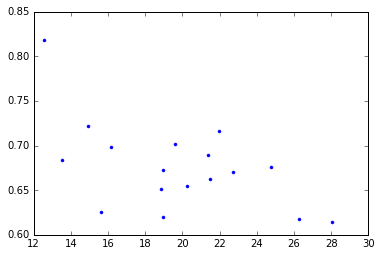

In [104]:
ind = 0
plt.plot(shots[:,ind],g_n[:,ind],'.')

# plt.ylim(-100,100)

In [105]:
g_n.shape[-1]

2239810

In [65]:
degree = 5

calibrated_curves = np.zeros_like(shots)
coefs=np.zeros((degree+1))
for ii in range(g_n.shape[-1]):
    cn = getCorrectionFunc(dmat = g_n[:,ii], i = shots[:,ii],order=degree)
    calibrated_curves[:,ii] = cn(shots[:,ii])

In [66]:
calibrated_shots = shots*calibrated_curves

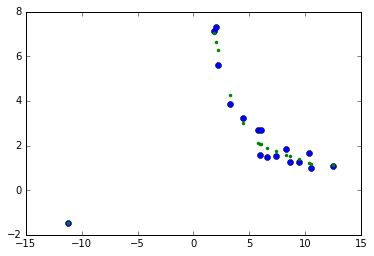

In [90]:
ind = 710
plt.plot(shots[:,ind],g_n[:,ind],'o')

# plt.plot(mean_int,g_n[:,ind],'o')

plt.plot(shots[:,ind],calibrated_curves[:,ind],'.')
# plt.ylim(-10,10)
# ind+=1
# plt.plot(mean_int,g_n[:,ind],'o')

# plt.plot(mean_int,calibrated_curves[:,ind],'-')
# plt.ylim(0.6,1.5)


# ind+=50000
# plt.plot(mean_int,g_n[:,ind],'o')

# plt.plot(mean_int,calibrated_curves[:,ind],'-')
# plt.ylim(0.6,1.5)

In [89]:
shots.argmin(-1)

array([1985999, 1975583, 1468815,  865877, 1972578, 1468815, 1972578,
       1972578, 1972578, 1485450,  295192,  295192, 1972578, 1471932,
       1972578,     710, 1485450])

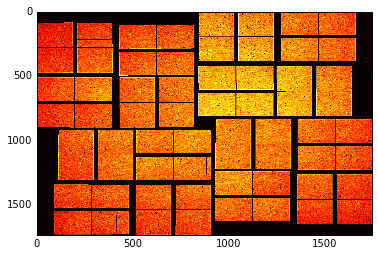

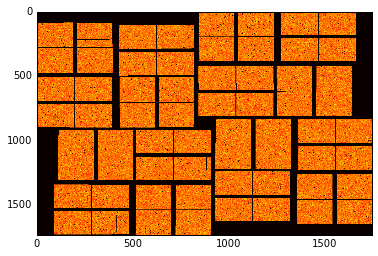

In [74]:
ii=10
plt.imshow( unflatten_shots(shots[ii][None,:],mask)[0], 
         aspect='auto', cmap='hot',vmin=10,vmax=18)
plt.figure()
plt.imshow( unflatten_shots(calibrated_shots[ii][None,:],mask)[0], 
         aspect='auto', cmap='hot',vmin=10,vmax=18)
# plt.colorbar()

In [70]:
single_int_dir = '/reg/d/psdm/cxi/cxilr6716/scratch/flatfield_calibration/flat_det_imgs/'
f_imgs = h5py.File(os.path.join(single_int_dir,'fullImgs_run%d.h5'%run))
print f_imgs.keys()

[u'ave_tot_int', u'ebeam', u'event_time', u'evr', u'fiducials', u'flat_img', u'gas_detector', u'phase_cav']


In [71]:
single_shots = f_imgs['flat_img'][1000:1200]
single_shots_int = single_shots.mean(-1)
selection_mask = (single_shots_int>mean_int.min())*(single_shots_int<mean_int.max())
single_shots=single_shots[selection_mask]
single_shots_int=single_shots_int[selection_mask]


In [77]:
single_shot_calibration_curves=cn(single_shots_int)
calibrated_single_shots = single_shots*single_shot_calibration_curves

In [109]:
((single_shots[1]>shots.min(0))*(single_shots[1]<shots.max(0))).sum()

185179

array([ True,  True,  True, ...,  True, False, False], dtype=bool)

In [108]:
print single_shots[0].shape

(2239810,)


In [122]:
calibrated_std=calibrated_single_shots.std(-1)
single_shot_std=single_shots.std(-1)

19.0548 58.5845526037


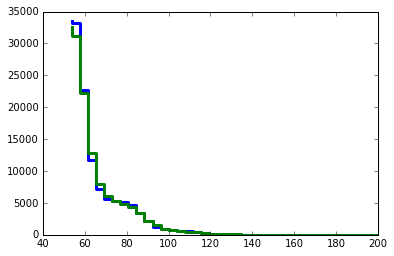

In [133]:
single_shot_std.shape
calibrated_std.shape
ii=143
bins=np.linspace(50,200,40)
hist = np.histogram(single_shots[ii],bins)
hist_cali = np.histogram(calibrated_single_shots[ii],bins)

plt.step(hist[1][1:], hist[0],
        linewidth=3)


plt.step(hist_cali[1][1:], hist_cali[0],
        linewidth=3)
print single_shots[ii].std(), calibrated_single_shots[ii].std()

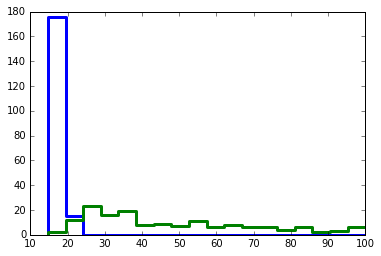

In [125]:
bins=np.linspace(10,100,20)
hist = np.histogram(single_shot_std,bins)
hist_cali = np.histogram(calibrated_std,bins)

plt.step(hist[1][1:], hist[0],
        linewidth=3)


plt.step(hist_cali[1][1:], hist_cali[0],
        linewidth=3)

(array([  7.,  14.,  14.,  38.,  44.,  32.,  25.,   9.,   5.,   3.]),
 array([  9.51541519,  10.24059277,  10.96577034,  11.69094791,
         12.41612549,  13.14130306,  13.86648064,  14.59165821,
         15.31683578,  16.04201336,  16.76719093]),
 <a list of 10 Patch objects>)

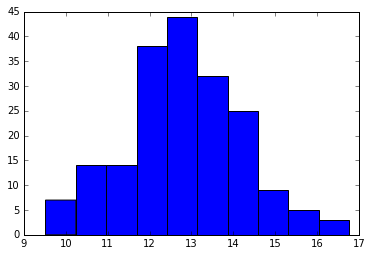

In [88]:
plt.hist(single_shots_int)

In [157]:
mean_int

array([  9.25419724,   9.75516357,  10.28537616,  10.76672805,
        11.26836219,  11.77168425,  12.27107494,  12.75689964,
        13.26188558,  13.75241652,  14.23883268,  14.74237893,
        15.2271005 ,  15.73615121,  16.2294604 ,  16.73748934,  17.24597235])

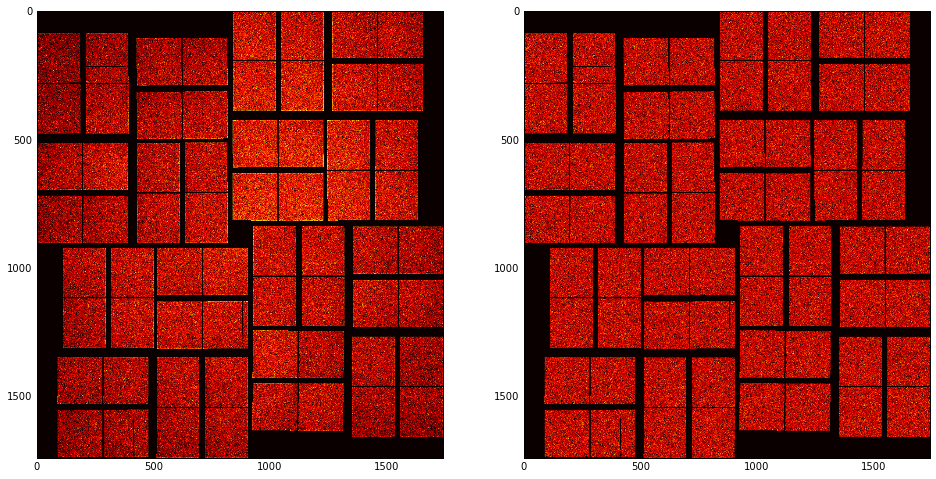

In [116]:
shots_mean=single_shots.mean(0)
cali_mean=calibrated_single_shots.mean(0)
plt.figure(figsize=[16,8])
plt.subplot(121)
plt.imshow( unflatten_shots(shots_mean[None,:],mask)[0], 
         aspect='auto', cmap='hot',vmin=10,vmax=20)

plt.subplot(122)
plt.imshow( unflatten_shots(cali_mean[None,:],mask)[0], 
         aspect='auto', cmap='hot',vmin=10,vmax=20)
# plt.colorbar()

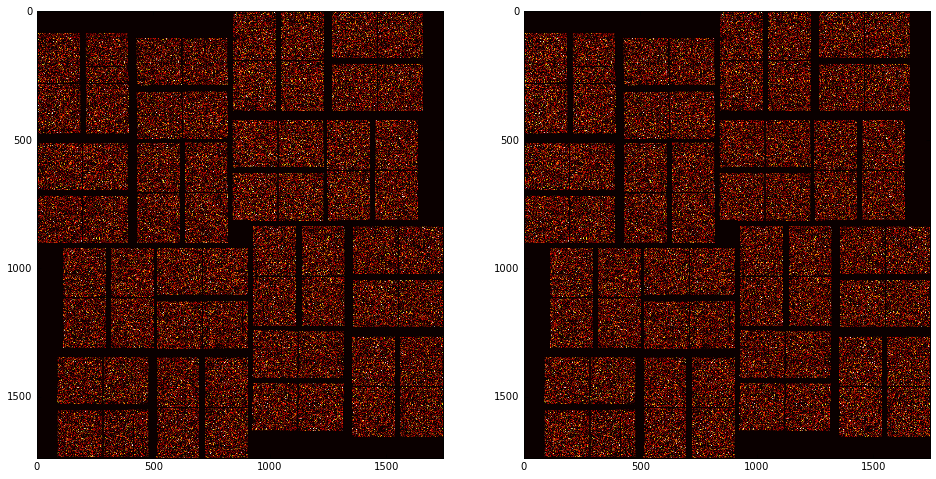

In [98]:
ii=100
plt.figure(figsize=[16,8])
plt.subplot(121)
plt.imshow( unflatten_shots(single_shots[ii][None,:],mask)[0], 
         aspect='auto', cmap='hot',vmin=10,vmax=80)

plt.subplot(122)
plt.imshow( unflatten_shots(calibrated_single_shots[ii][None,:],mask)[0], 
         aspect='auto', cmap='hot',vmin=10,vmax=80)

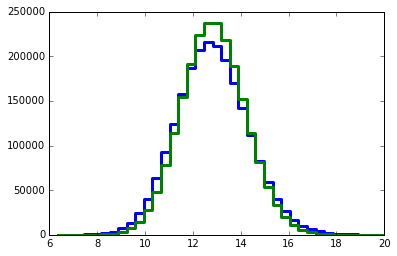

In [115]:
ii=143
bins=np.linspace(6,20,40)
hist = np.histogram(single_shots.mean(0),bins)
hist_cali = np.histogram(calibrated_single_shots.mean(0),bins)

plt.step(hist[1][1:], hist[0],
        linewidth=3)


plt.step(hist_cali[1][1:], hist_cali[0],
        linewidth=3)

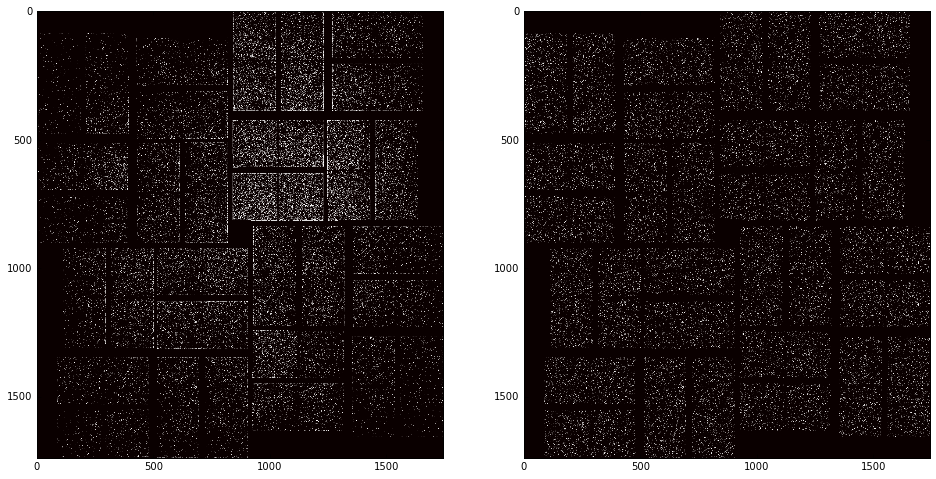

In [196]:
plt.figure(figsize=[16,8])
plt.subplot(121)
plt.imshow( unflatten_shots((shots_mean>15)[None,:],mask)[0], 
         aspect='auto', cmap='hot',vmin=0,vmax=1)

plt.subplot(122)
plt.imshow( unflatten_shots((cali_mean>15)[None,:],mask)[0], 
         aspect='auto', cmap='hot',vmin=0,vmax=1)
# plt.colorbar()

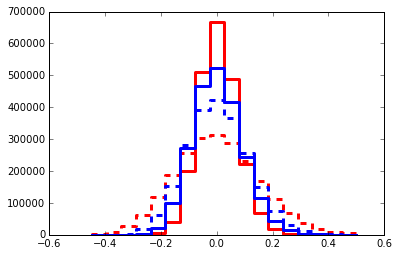

In [193]:
x=7
y=16
diff= (shots[y]/ mean_int[y])/(shots[x]/ mean_int[x])-1
s1=calibrated_shots[x]
s2=calibrated_shots[y]
cali_diff=(s2/s2.mean())/(s1/s1.mean())-1


hist=np.histogram(diff,bins=np.linspace(-0.5,0.5,20))
plt.step(hist[1][1:], hist[0], linewidth=3,linestyle='--',
        color='r')
hist=np.histogram(cali_diff,bins=np.linspace(-0.5,0.5,20))
plt.step(hist[1][1:], hist[0], linewidth=3,linestyle='-',
        color='r')

# x=7
y=15
diff= (shots[y]/ mean_int[y])/(shots[x]/ mean_int[x])-1
s1=calibrated_shots[x]
s2=calibrated_shots[y]
cali_diff=(s2/s2.mean())/(s1/s1.mean())-1

hist=np.histogram(diff,bins=np.linspace(-0.5,0.5,20))
plt.step(hist[1][1:], hist[0], linewidth=3,linestyle='--',
        color='b')
hist=np.histogram(cali_diff,bins=np.linspace(-0.5,0.5,20))
plt.step(hist[1][1:], hist[0], linewidth=3,linestyle='-',
        color='b')

(array([  2.50000000e+01,   2.60000000e+01,   6.00000000e+01,
          1.48000000e+02,   6.05000000e+02,   4.56500000e+03,
          3.90560000e+04,   2.00826000e+05,   5.11262000e+05,
          6.68050000e+05,   4.87730000e+05,   2.20840000e+05,
          6.93370000e+04,   1.66920000e+04,   3.60400000e+03,
          6.50000000e+02,   1.35000000e+02,   3.90000000e+01,
          1.60000000e+01]),
 array([-0.5       , -0.44736842, -0.39473684, -0.34210526, -0.28947368,
        -0.23684211, -0.18421053, -0.13157895, -0.07894737, -0.02631579,
         0.02631579,  0.07894737,  0.13157895,  0.18421053,  0.23684211,
         0.28947368,  0.34210526,  0.39473684,  0.44736842,  0.5       ]),
 <a list of 19 Patch objects>)

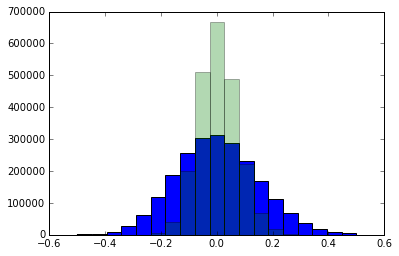

In [178]:
plt.hist(diff,bins=np.linspace(-0.5,0.5,20))
plt.hist(cali_diff,bins=np.linspace(-0.5,0.5,20), alpha=0.3)

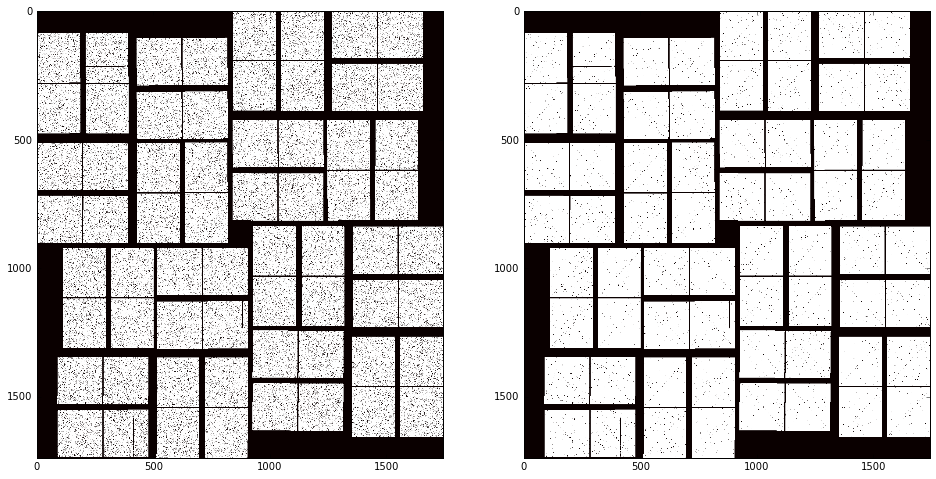

In [181]:
plt.figure(figsize=[16,8])
plt.subplot(121)
plt.imshow( unflatten_shots((diff>-0.2)[None,:],mask)[0]*mask, 
         aspect='auto', cmap='hot',vmin=0,vmax=1)

plt.subplot(122)
plt.imshow( unflatten_shots((cali_diff>-0.2)[None,:],mask)[0]*mask, 
         aspect='auto', cmap='hot',vmin=0,vmax=1)

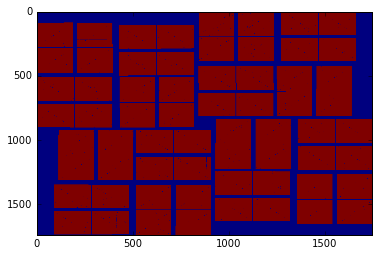

In [169]:
plt.imshow(ref_mask,aspect='auto')

In [170]:
ref_mask.sum()

2239810